In [1]:
!git clone https://github.com/akmeraki/TRACK.git


Cloning into 'TRACK'...
remote: Enumerating objects: 41540, done.
remote: Total 41540 (delta 0), reused 0 (delta 0), pack-reused 41540
Receiving objects: 100% (41540/41540), 529.33 MiB | 13.78 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (41518/41518), done.


In [2]:
!ls

sample_data  TRACK


In [3]:
cd TRACK

/content/TRACK


In [4]:
!ls

driving_log.csv  IMG


In [5]:
# importing the libraries

import numpy as np
import matplotlib.pyplot as plt
import keras 
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import ntpath
import cv2
from imgaug import augmenters as iaa 
import matplotlib.image as mpimg
import pandas as pd
import random
import os


Using TensorFlow backend.


In [6]:
# Reading from the CSV file

data_dir='/content/TRACK'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv('driving_log.csv',names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

center  \
0  IMG/center_2016_12_01_13_30_48_287.jpg   
1  IMG/center_2016_12_01_13_30_48_404.jpg   
2  IMG/center_2016_12_01_13_31_12_937.jpg   
3  IMG/center_2016_12_01_13_31_13_037.jpg   
4  IMG/center_2016_12_01_13_31_13_177.jpg   

                                    left  \
0   IMG/left_2016_12_01_13_30_48_287.jpg   
1   IMG/left_2016_12_01_13_30_48_404.jpg   
2   IMG/left_2016_12_01_13_31_12_937.jpg   
3   IMG/left_2016_12_01_13_31_13_037.jpg   
4   IMG/left_2016_12_01_13_31_13_177.jpg   

                                    right  steering  throttle  reverse  \
0   IMG/right_2016_12_01_13_30_48_287.jpg  0.0       0.0       0.0       
1   IMG/right_2016_12_01_13_30_48_404.jpg  0.0       0.0       0.0       
2   IMG/right_2016_12_01_13_31_12_937.jpg  0.0       0.0       0.0       
3   IMG/right_2016_12_01_13_31_13_037.jpg  0.0       0.0       0.0       
4   IMG/right_2016_12_01_13_31_13_177.jpg  0.0       0.0       0.0       

       speed  
0  22.148290  
1  21.879630  
2  1.453011   
3  1.438419   
4  1.418236

In [7]:
# Cutting the path for simpler viewing

def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2016_12_01_13_30_48_287.jpg  left_2016_12_01_13_30_48_287.jpg   
1  center_2016_12_01_13_30_48_404.jpg  left_2016_12_01_13_30_48_404.jpg   
2  center_2016_12_01_13_31_12_937.jpg  left_2016_12_01_13_31_12_937.jpg   
3  center_2016_12_01_13_31_13_037.jpg  left_2016_12_01_13_31_13_037.jpg   
4  center_2016_12_01_13_31_13_177.jpg  left_2016_12_01_13_31_13_177.jpg   

                               right  steering  throttle  reverse      speed  
0  right_2016_12_01_13_30_48_287.jpg  0.0       0.0       0.0      22.148290  
1  right_2016_12_01_13_30_48_404.jpg  0.0       0.0       0.0      21.879630  
2  right_2016_12_01_13_31_12_937.jpg  0.0       0.0       0.0      1.453011   
3  right_2016_12_01_13_31_13_037.jpg  0.0       0.0       0.0      1.438419   
4  right_2016_12_01_13_31_13_177.jpg  0.0       0.0       0.0      1.418236

In [8]:
# Displaying the number of bins and center as zero
n_bins = 25
samples_per_bin = 800
hist,bins = np.histogram(data['steering'],n_bins)
print(bins)

center = (bins[:-1]+ bins[1:])*0.5
print(center)

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]
[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


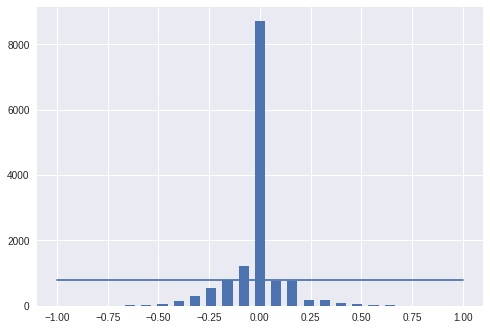

In [9]:
#  Plotting the Histogram of steering angles
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

removed: 8315
remaining 5524


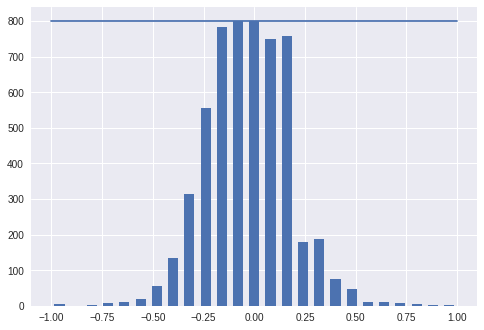

In [10]:
#  Removing a significant amount of steering angle bias 

remove_lst = []
for j in range(n_bins):
  lst=[]
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      lst.append(i)
  lst = shuffle(lst)
  lst = lst[samples_per_bin:]
  remove_lst.extend(lst)
print('removed:',len(remove_lst))
data.drop(data.index[remove_lst],inplace = True)
print('remaining',len(data))

hist, _ = np.histogram(data['steering'],n_bins)
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [0]:
#  Loading the steering angle and center camera -Image data from directory 

print(data.iloc[1000])

def load_img_steering(data_dir,df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center,left,right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(data_dir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)  
  steerings = np.asarray(steering)
  return image_paths, steerings 

image_paths, steerings = load_img_steering(data_dir +'/IMG',data)
  

center      center_2016_12_01_13_36_30_259.jpg
left        left_2016_12_01_13_36_30_259.jpg  
right       right_2016_12_01_13_36_30_259.jpg 
steering    0.176582                          
throttle    0.985533                          
reverse     0                                 
speed       30.1857                           
Name: 2289, dtype: object


In [0]:
# Displaying Image paths

print(image_paths[0])
print(steerings)
print(len(image_paths))
print(len(steerings))


/content/TRACK/IMG/center_2016_12_01_13_31_13_786.jpg
[ 0.          0.          0.         ... -0.2037234  -0.07217073
 -0.2508023 ]
4612
4612


In [0]:
#  Spliting the data into Training and Validation data
X_train, X_valid , Y_train, Y_valid = train_test_split (image_paths, steerings, test_size = 0.2, random_state = 6 )

In [0]:
# Visualizing the Training and Validation data 

print('Training Samples :',len(X_train))
print('Valid Samples :',len(X_valid))
print(len(Y_train))
print(len(Y_valid))
print(X_train[0])
print(X_valid[0])
print(X_train.shape)
print(X_valid.shape)

Training Samples : 3689
Valid Samples : 923
3689
923
/content/TRACK/IMG/center_2016_12_01_13_42_37_520.jpg
/content/TRACK/IMG/center_2016_12_01_13_36_54_327.jpg
(3689,)
(923,)


Text(0.5,1,'Validation set')

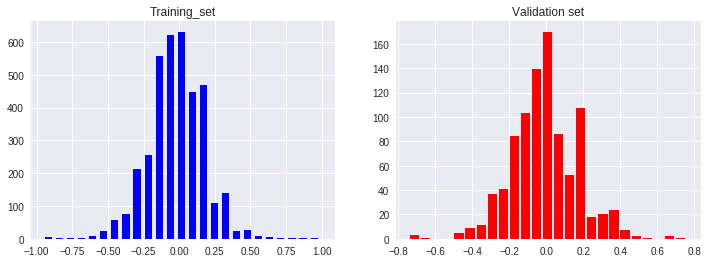

In [0]:
#  Visualizing the Training and validation data in the form of  Histograms

fig, axs = plt.subplots(1,2,figsize=(12,4))

axs[0].hist(Y_train, bins = n_bins, width = 0.05 , color = 'blue')
axs[0].set_title('Training_set')
axs[1].hist(Y_valid, bins = n_bins, width = 0.05, color = 'red')
axs[1].set_title('Validation set')

In [0]:
# Zooming --For Augmentation
def zoom (image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5,1,'Zoomed Image')

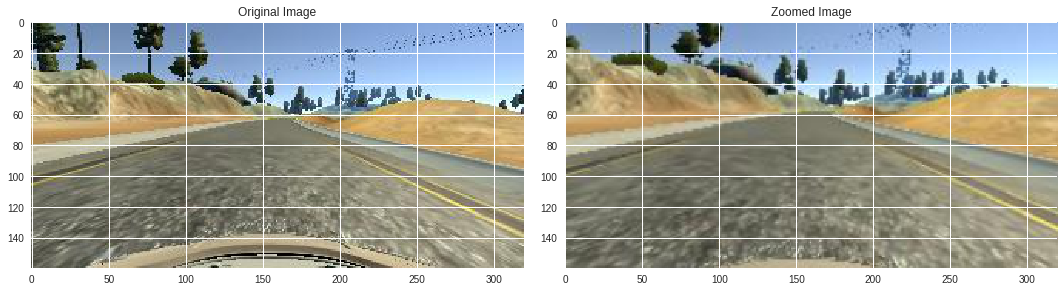

In [0]:
#  Displaying the Comparison of Zoomed and Original Image
image = image_paths[random.randint(0, 2000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [0]:
# Img_preprocessing -- Cutting out unnecessary data in the image 
#  Changing the shape to 

def img_preprocessing(img):
  img =img[60:135,:,:]
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV) 
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img,(200,66))
  img = img/255
  return img
  

Text(0.5,1,'preprocessed_image')

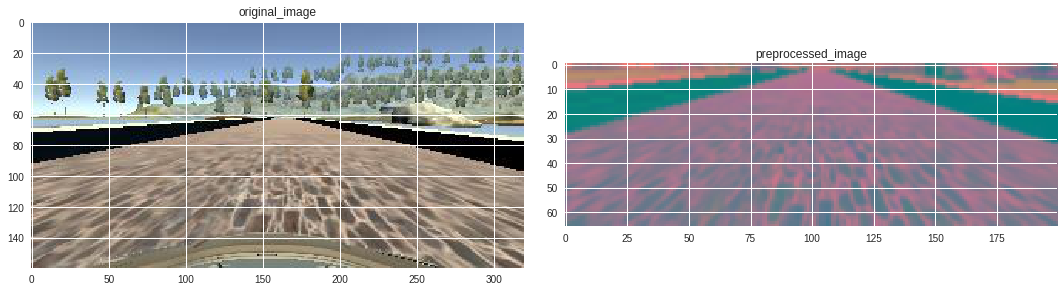

In [0]:
#  Displaying the Comparison of Preprocessed and Original Image

image = image_paths[random.randint(0, 1000)]
str_angle= steerings[random.randint(0, 1000)]
original_img = mpimg.imread(image)
preprocessed_img = img_preprocessing(original_img)


fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_img)
axs[0].set_title('original_image')
axs[1].imshow(preprocessed_img)
axs[1].set_title('preprocessed_image')




In [0]:
# Panning --For Augmentation
def pan(image):
  pan = iaa.Affine(translate_percent = {"x" : (-0.1,0.1), "y" : (-0.1,0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5,1,'panned_image')

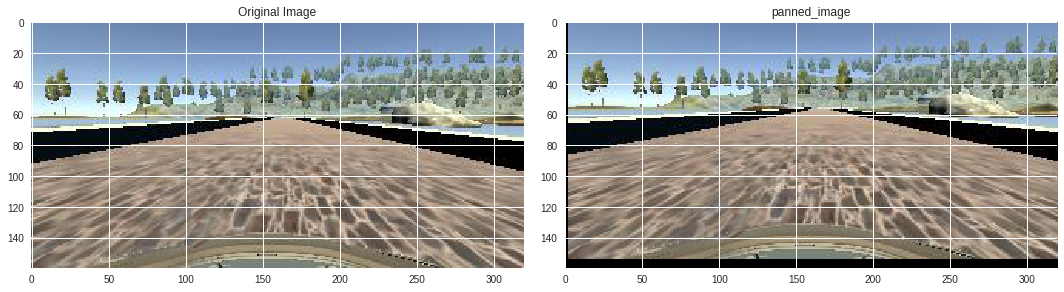

In [0]:
#  Displaying the Comparison of Panning and Original Image

panned_image = pan(original_img)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_img)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('panned_image')

In [0]:
# Changing brightness of an image --For Augmentation

def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5,1,'brightness_altered_image')

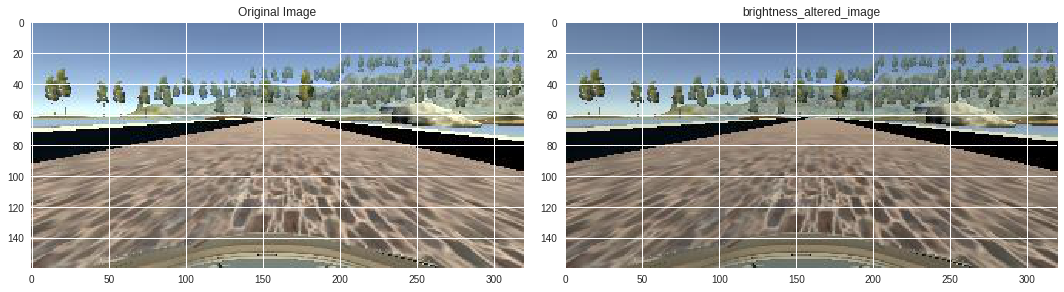

In [0]:
#  Displaying the Comparison of random_brightness_image and Original Image

brightness_altered_image = img_random_brightness(original_img)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_img)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('brightness_altered_image')

In [0]:
# Flipping an image --For Augmentation

def flip(image,steering_angle):
  image = cv2.flip(image,1)
  steering_angle = -1*steering_angle
  return image,steering_angle

0.18615079999999998
-0.18615079999999998


Text(0.5,1,'flipped_image-Flipped Steering Angle :-0.18615079999999998')

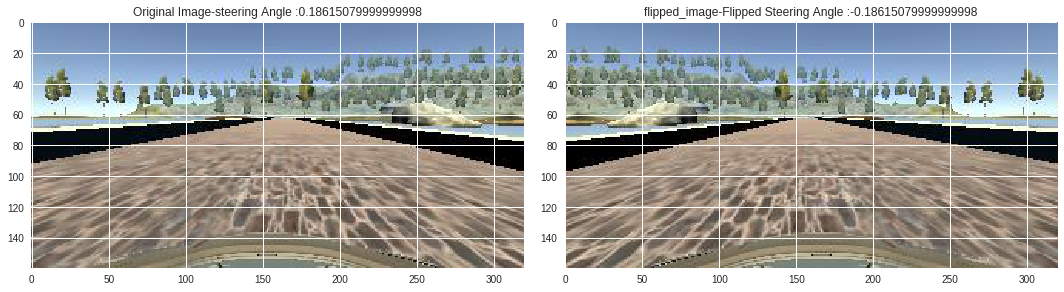

In [0]:
#  Displaying the Comparison of Flipped Image and Original Image

flipped_image,flipped_steering_angle = flip(original_img,str_angle)

print(str_angle)
print(flipped_steering_angle)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_img)
axs[0].set_title('Original Image' +'-'+ 'steering Angle :'  + str(str_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('flipped_image' +'-' 'Flipped Steering Angle :' + str(flipped_steering_angle))

0.18615079999999998
-0.18615079999999998


Text(0.5,1,'flipped_image-Flipped Steering Angle :-0.18615079999999998')

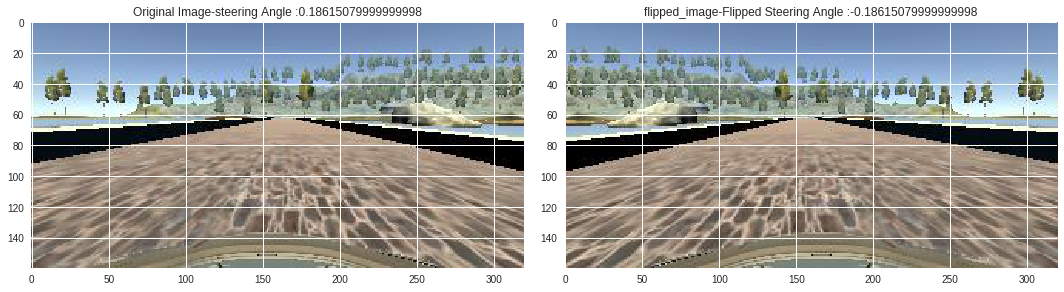

In [0]:
#  Displaying the Comparison of Flipped Image and Original Image

flipped_image,flipped_steering_angle = flip(original_img,str_angle)

print(str_angle)
print(flipped_steering_angle)

fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_img)
axs[0].set_title('Original Image' +'-'+ 'steering Angle :'  + str(str_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('flipped_image' +'-' 'Flipped Steering Angle :' + str(flipped_steering_angle))

In [0]:
# Random Augment function 

def random_augment(image,steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = flip(image,steering_angle)  
  return image, steering_angle  
    

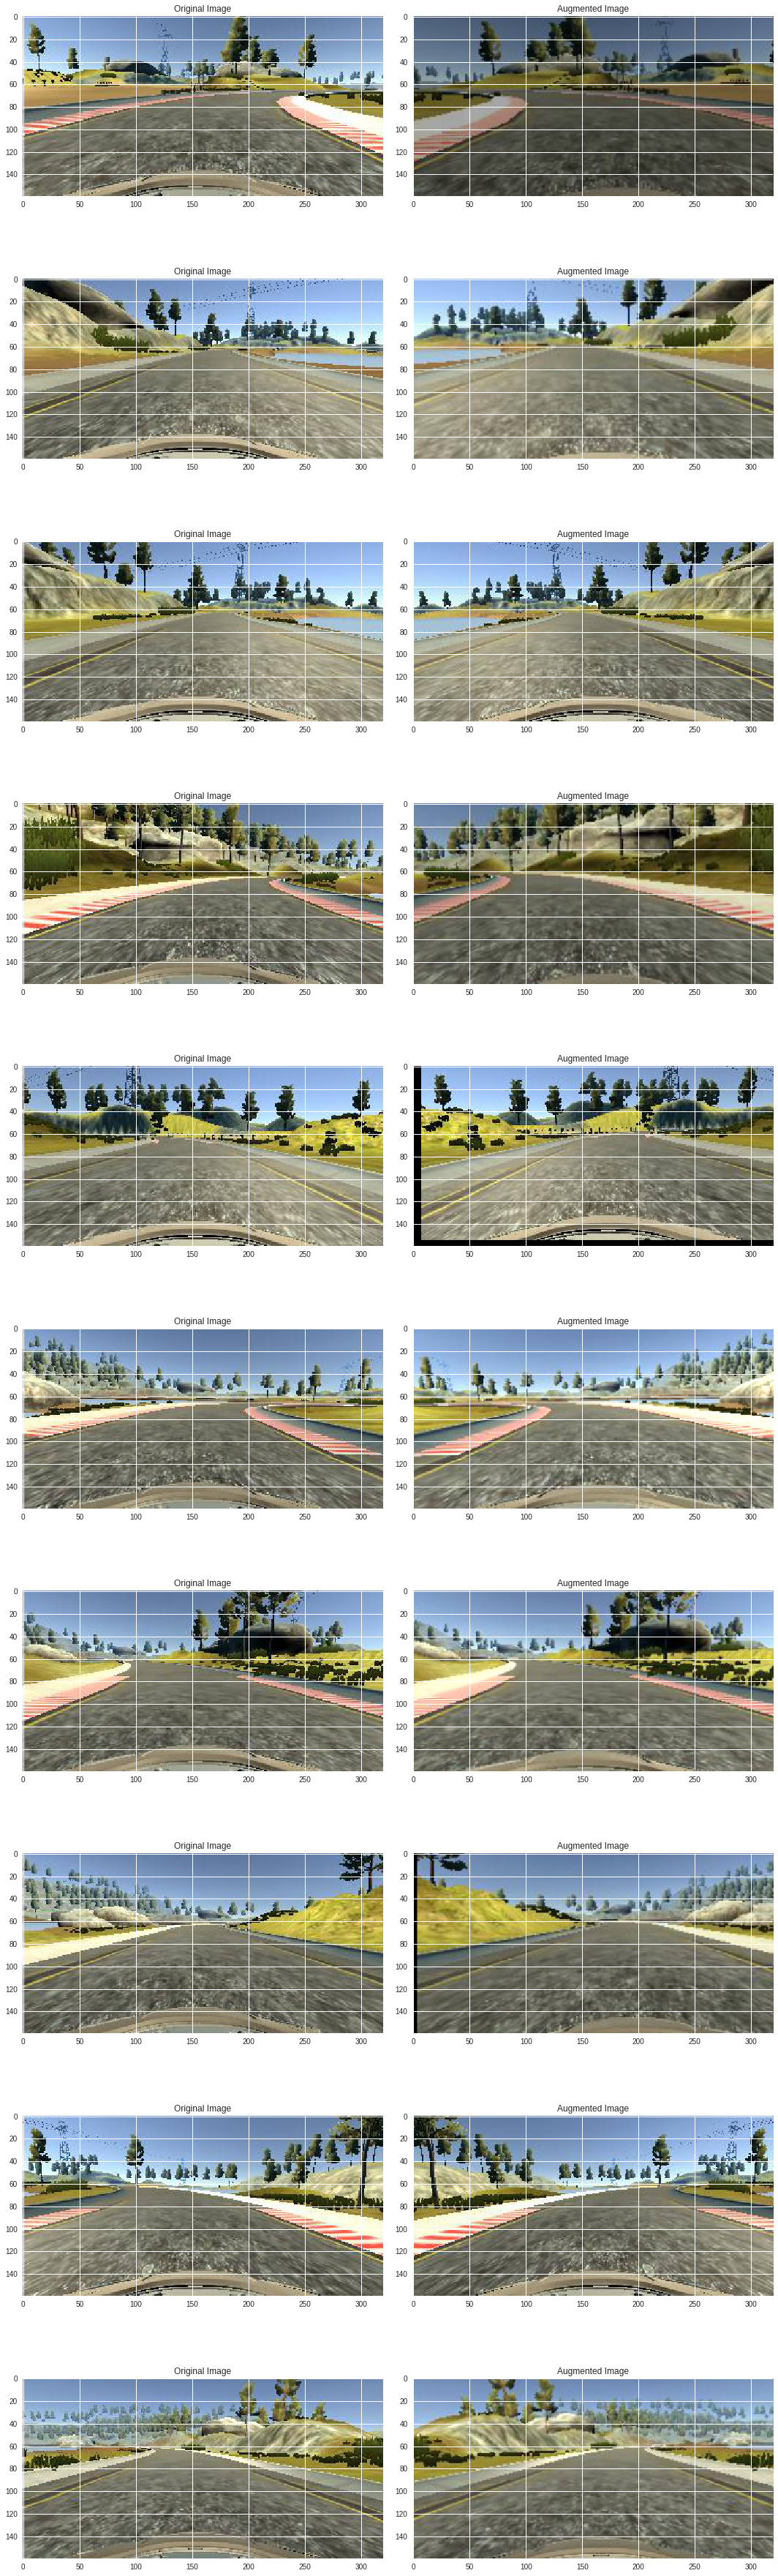

In [0]:
# Displaying the comparison of Augmented images with the Original Images 

ncols = 2
nrows = 10

fig, axs = plt.subplots(nrows,ncols,figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0,len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering_= random_augment(random_image,random_steering)
  
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')
  



In [0]:
# Batch Generator for the model fit function--> Generates augmented imags in batches

def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0,len(image_paths)-1)
      
      if istraining:
        im,steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else :
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocessing(im)
      batch_img.append(im)
      batch_steering.append(steering)
      
    yield (np.asarray(batch_img),np.asarray(batch_steering))  

Text(0.5,1,'Validation_image')

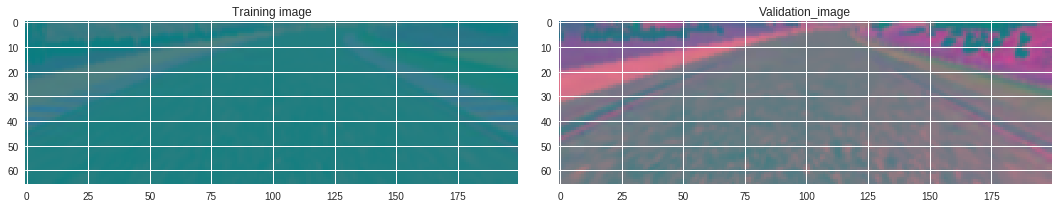

In [0]:
#  Augmented batch generated Training data ---> Validation data doesn't get augmented
X_train_gen,Y_train_gen = next(batch_generator( X_train, Y_train, 1,1))
X_valid_gen,Y_valid_gen = next(batch_generator( X_valid, Y_valid, 1,0))


fig,axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training image')
axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validation_image')

Epoch 1/10


UnknownError: ignored